# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
import itertools

# Sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# Importing Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DataMiningProject/SLI_data/SLI_INTERSPEECH2009_Functionals.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data Mining/Data Mining Project/SLI_data/SLI_eGeMAPSv02_Functionals_Final.csv')

# Setup

## Train Test split

we have 98 children in our dataset. 44 healthy kids and 54 children suffering from SLI. I've chosen 10 children to be in test data. half of them (5) are healthy.

In [ ]:
# P 10, 20, 32, 43, 56
# H 26, 35, 44, 51, 68
## selected children to be in test data


df_test = df[df['patient_ID'].isin(['P10', 'P20', 'P32', 'P43', 'P56', 'H26', 'H35', 'H44', 'H51', 'H68']) ]
df_train = df.drop(df_test.index)
df_train.shape, df_test.shape


((3432, 90), (376, 90))

In [ ]:
X_train = df_train.drop(['Label', 'patient_ID'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label', 'patient_ID'], axis=1)
y_test = df_test['Label']
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3432, 88), (376, 88), (3432,), (376,))

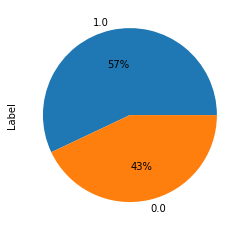

In [ ]:
df_train['Label'].value_counts().plot(kind='pie', autopct='%1.0f%%')

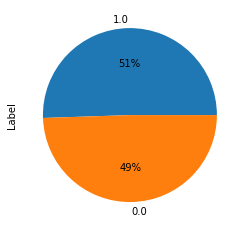

In [ ]:
df_test['Label'].value_counts().plot(kind='pie', autopct='%1.0f%%')

## Determine Baseline 

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf_scores = cross_val_score(dummy_clf, X_train, y_train, cv=6)
print(dummy_clf_scores) ## mean accuracy
print(dummy_clf_scores.mean())

[0.57167832 0.57167832 0.57167832 0.56993007 0.56993007 0.56993007]
0.5708041958041958


# Modelling

## Decision Tree

In [ ]:
dc_tree = DecisionTreeClassifier()
dc_tree_scores = cross_val_score(dc_tree, X_train, y_train, cv=6)
print(dc_tree_scores)
print(dc_tree_scores.mean())

[0.88986014 0.97902098 0.87412587 0.81293706 0.97552448 0.98776224]
0.9198717948717948


### Hyperparameter Tuning

In [ ]:
parameters = {'criterion':['gini', 'entropy'],
              'max_depth':list(range(2,80)),
              'min_samples_split':list(range(2,20)),
              'min_samples_leaf':list(range(1,10))}

dc_tree = DecisionTreeClassifier(random_state = 42)
clf = RandomizedSearchCV(estimator=dc_tree,
                         param_distributions=parameters,
                         n_iter=70,
                         cv=6,)
clf = clf.fit(X=X_train, y=y_train)
clf.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [ ]:
parameters = {'max_depth':[25,30,50,55,60,70],
              'min_samples_split':[15,20,25,30,35],
              'min_samples_leaf':[3,4,5,6,8]}

dc_tree = DecisionTreeClassifier(random_state = 42, criterion='entropy')
clf = GridSearchCV(estimator=dc_tree,
                   param_grid=parameters,
                   cv=6)
clf = clf.fit(X=X_train, y=y_train)
clf.best_params_

{'max_depth': 25, 'min_samples_leaf': 6, 'min_samples_split': 35}

In [ ]:
dc_tree_scores = cross_val_score(clf.best_estimator_, X_train, y_train, cv=6)
print(dc_tree_scores)
print(dc_tree_scores.mean())

[0.98076923 0.98776224 0.86888112 0.83391608 0.99125874 0.98951049]
0.942016317016317


## SVM

In [ ]:
svm_clf = SVC()
svm_clf_scores = cross_val_score(svm_clf, X_train, y_train, cv=6)
print(svm_clf_scores)
print(svm_clf_scores.mean())

[0.98601399 0.9965035  0.88811189 0.95104895 0.9965035  0.9965035 ]
0.9691142191142191


### Hyperparameter Tuning

In [ ]:
## Checked both poly and the other, poly perfomance was better so we chose this one

parameters = {'C':[0.5, 0.7, 1.0, 2.0, 4.0, 6.0, 8.0, 12.0, 15.0, 25.0],
              'degree':list(range(2,7))}

svm = SVC(random_state=42, kernel="poly")
clf = GridSearchCV(estimator=svm,
                   param_grid=parameters,
                   cv=6)
clf = clf.fit(X=X_train, y=y_train)
clf.best_params_

{'C': 0.5, 'degree': 5}

In [ ]:
parameters = {'C':[0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 12.0, 25.0],
              'kernel':['linear', 'rbf', 'sigmoid'],
              }
svm = SVC(random_state=42)
clf = GridSearchCV(estimator=svm,
                   param_grid=parameters,
                   cv=6)
clf = clf.fit(X=X_train, y=y_train)
clf.best_params_

{'C': 7.0, 'kernel': 'linear'}

In [ ]:
svm_scores = cross_val_score(clf.best_estimator_, X_train, y_train, cv=6)
print(svm_scores)
print(svm_scores.mean())

[0.98076923 0.99300699 0.91083916 0.96853147 0.99825175 0.9965035 ]
0.9746503496503497


## Neural Networks

In [ ]:
mlp_clf = MLPClassifier()
mlp_clf_score = cross_val_score(mlp_clf, X_train, y_train, cv=6)
print(mlp_clf_score)
print(mlp_clf_score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[0.97027972 0.99475524 0.87587413 0.96328671 0.9965035  0.99825175]
0.9664918414918415


### Hyperparameter Tuning

In [ ]:
num_layer_fixed = [(randint(55, 550)),
                    (randint(55, 550)),
                    (randint(55, 550)),
                    (randint(55, 550)),
                    (randint(55, 550)),
                    (randint(55, 550))]
            
parameters = {'solver':['adam', 'sgd'],
                'learning_rate_init': [1e-2, 1e-3, 1e-4],
                'hidden_layer_sizes':num_layer_fixed,
                'activation':['tanh', 'relu']}

mlp = MLPClassifier(random_state=42)
clf = GridSearchCV(estimator=mlp,
                         param_grid=parameters,
                         cv=6)
clf = clf.fit(X=X_train, y=y_train)
clf.best_params_


# {'activation': 'tanh',
#  'hidden_layer_sizes': 399,
#  'learning_rate_init': 0.01,
#  'solver': 'adam'}

#  0.979

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

{'activation': 'tanh',
 'hidden_layer_sizes': 399,
 'learning_rate_init': 0.01,
 'solver': 'adam'}

In [ ]:
layers = [(200),(200,100),(200,100,50)]
            
parameters = {'learning_rate_init': [1e-2, 1e-3],
              'hidden_layer_sizes':layers,
              'activation':['tanh', 'relu']}

mlp = MLPClassifier(random_state=42, solver='adam')
clf = GridSearchCV(estimator=mlp,
                   param_grid=parameters,
                   cv=6)
clf = clf.fit(X=X_train, y=y_train)
clf.best_params_

# {'activation': 'relu',
#  'hidden_layer_sizes': (200, 100),
#  'learning_rate_init': 0.001}
# 0.978


{'activation': 'relu',
 'hidden_layer_sizes': (200, 100),
 'learning_rate_init': 0.001}

In [ ]:
layers = [(400),(300,150),(200,100)]
            
parameters = {'learning_rate_init': [1e-2, 1e-3],
              'hidden_layer_sizes':layers,
              'activation':['tanh', 'relu']}

mlp = MLPClassifier(random_state=42, solver='adam')
clf = GridSearchCV(estimator=mlp,
                   param_grid=parameters,
                   cv=6)
clf = clf.fit(X=X_train, y=y_train)
clf.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': 400, 'learning_rate_init': 0.01}

In [ ]:
mlp_clf_score = cross_val_score(clf.best_estimator_, X_train, y_train, cv=6)
print(mlp_clf_score)
print(mlp_clf_score.mean())

[0.98251748 0.97552448 0.95804196 0.96153846 1.         0.9965035 ]
0.9790209790209791


## Ensemble Methods

### Stacking

In [ ]:
base_models = [
              ('mlp', MLPClassifier(random_state=42,
                                    solver='adam',
                                    activation='tanh',
                                    hidden_layer_sizes=(400),
                                    learning_rate_init=0.01)),
              ('svm', SVC(random_state=42, kernel="poly", C=0.5, degree=5)), 
              ('dc_tree', DecisionTreeClassifier(random_state = 42,
                                                criterion='entropy',
                                                max_depth=25,
                                                min_samples_leaf=6,
                                                min_samples_split=35)),
]
meta_model = LogisticRegression(random_state = 42)
stacked_model = StackingClassifier(random_state = 42, estimators=base_models, final_estimator=meta_model, cv=10)

In [ ]:
stacked_model_score = cross_val_score(stacked_model, X_train, y_train, cv=6)
print(stacked_model_score)
print(stacked_model_score.mean())

[0.97552448 0.99300699 0.91433566 0.96853147 0.99825175 0.9965035 ]
0.9743589743589745


### Adaboost

without hyper parameter tuning

In [ ]:
ABC = AdaBoostClassifier(random_state=42)
ada_clf_score = cross_val_score(ABC, X_train, y_train, cv=6)
print(ada_clf_score)
print(ada_clf_score.mean())

[0.97902098 0.99825175 0.87412587 0.92132867 0.9965035  0.9965035 ]
0.960955710955711


Hyper-parameter tuning

In [ ]:
param_grid = {"n_estimators" : np.arange(1, 70, 10),
              "learning_rate": np.arange(0.5, 1.6, 0.1), 
             }

ABC = AdaBoostClassifier(random_state=42)
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid)
grid_search_ABC = grid_search_ABC.fit(X=X_train, y=y_train)
grid_search_ABC.best_params_

{'learning_rate': 1.4, 'n_estimators': 41}

In [ ]:
ada_clf_score = cross_val_score(grid_search_ABC.best_estimator_, X_train, y_train, cv=6)
print(ada_clf_score)
print(ada_clf_score.mean())

[0.98601399 0.98951049 0.88461538 0.91433566 0.99300699 0.99300699]
0.9600815850815851


### Gradient Boosting tree (XGBoost)

without hyper parameter tuning

In [ ]:
xgb = XGBClassifier()
xgb_clf_score = cross_val_score(xgb, X_train, y_train, cv=6)
print(xgb_clf_score)
print(xgb_clf_score.mean())

[0.97727273 0.99825175 0.86188811 0.87762238 0.99825175 0.9965035 ]
0.9516317016317016


with hyper parameter tuning

In [ ]:
param_grid = {
'max_depth': range(2, 80),
'learning_rate': [0.01, 0.05, 0.09, 0.2, 0.3, 0.4, 0.9, 1.1, 1.25, 1.37, 1.4],
'alpha': np.arange(0, 50, 0.1)
}

xgb = XGBClassifier()
clf = RandomizedSearchCV(estimator=xgb,
                         param_distributions=param_grid,
                         n_iter=70,
                         cv=6,)
clf = clf.fit(X=X_train, y=y_train)
clf.best_params_

{'alpha': 32.0, 'learning_rate': 1.1, 'max_depth': 3}

In [ ]:
param_grid = {
'max_depth': range(2, 6),
'learning_rate': np.arange(0.9, 1.4, 0.2),
'alpha': np.arange(31.8, 32.5, 0.2)
}


g_search = GridSearchCV(estimator = xgb, param_grid = param_grid, return_train_score=True)
g_search.fit(X_train, y_train)
print(g_search.best_params_)

{'alpha': 31.8, 'learning_rate': 0.9, 'max_depth': 2}


In [ ]:
xgb = XGBClassifier(alpha=31.8, learning_rate=0.9, max_depth=3)
xgb_clf_score = cross_val_score(g_search.best_estimator_, X_train, y_train, cv=6)
print(xgb_clf_score)
print(xgb_clf_score.mean())

[0.98251748 0.9965035  0.8986014  0.91258741 1.         0.99475524]
0.9641608391608392


# Evaluation

## Comparing all models

In [ ]:
cv_results = {}

##### Decision Tree ######
dc_tree = DecisionTreeClassifier(random_state = 42,
                                 criterion='entropy',
                                 max_depth=25,
                                 min_samples_leaf=6,
                                 min_samples_split=35)

##### SVM ######
svm = SVC(random_state=42, kernel="poly", C=0.5, degree=5)

##### Multi Layer Perceptron ######
mlp = MLPClassifier(random_state=42,
                    solver='adam',
                    activation='tanh',
                    hidden_layer_sizes=(400),
                    learning_rate_init=0.01)

##### AdaBoost Classifier ######
abc = AdaBoostClassifier(learning_rate=1.4, n_estimators= 41)

##### Stacking Classifier ######
base_models = [('mlp', mlp),
              ('svm', svm), 
              ('dc_tree', dc_tree)]          
meta_model = LogisticRegression()
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=10)

##### XGB Classifier ######
xgb = XGBClassifier(alpha=31.8, learning_rate=0.9, max_depth=3)

##### Results ######
cv_results['DicisionTree'] = cross_val_score(dc_tree, X_train, y_train, cv=6)
cv_results['SVM'] = cross_val_score(svm, X_train, y_train, cv=6)
cv_results['NN'] = cross_val_score(mlp, X_train, y_train, cv=6)
cv_results['AdaBoost'] = cross_val_score(abc, X_train, y_train, cv=6)
cv_results['StackedModel'] = cross_val_score(stacked_model, X_train, y_train, cv=6)
cv_results['XGB'] = cross_val_score(xgb, X_train, y_train, cv=6)

cv_results_df = pd.DataFrame().from_dict(cv_results)


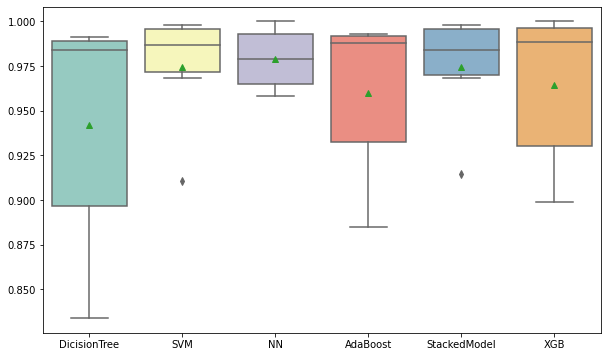

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=cv_results_df, showmeans=True, palette="Set3", ax=ax)

## Evaluating best model performance

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def get_metric(y_true, y_pred):
  model_metrics = {}
  model_metrics['accuracy'] = metrics.accuracy_score(y_true, y_pred)
  model_metrics['precision_score'] = metrics.precision_score(y_true, y_pred)
  model_metrics['recall_score'] = metrics.recall_score(y_true, y_pred)
  model_metrics['f1_score'] = metrics.f1_score(y_true, y_pred, average="micro")
  model_metrics['cm'] = metrics.confusion_matrix(y_true, y_pred)
  tn, fp, _, _ = metrics.confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
  model_metrics['specificity'] = float(tn / (tn + fp)) if (tn + fp) != 0 else 0
  return model_metrics

In [ ]:
## Best model Architecture

mlp = MLPClassifier(random_state=42,
                    solver='adam',
                    activation='tanh',
                    hidden_layer_sizes=(400),
                    learning_rate_init=0.01).fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)

In [ ]:
Train_metrics = get_metric(y_train, y_pred_train)
Test_metrics = get_metric(y_test, y_pred_test)

In [ ]:
print(f"Best model Train metrics:\n",
      f"accuracy: {Train_metrics['accuracy']}\n",
      f"precision: {Train_metrics['precision_score']}\n",
      f"recall: {Train_metrics['recall_score']}\n",
      f"f1: {Train_metrics['f1_score']}\n",
      f"specificity: {Train_metrics['specificity']}")

Best model Train metrics:
 accuracy: 0.9944638694638694
 precision: 0.9984583761562179
 recall: 0.9918325676365493
 f1: 0.9944638694638694
 specificity: 0.9979633401221996


In [ ]:
print(f"Best model Test metrics:\n",
      f"accuracy: {Test_metrics['accuracy']}\n",
      f"precision: {Test_metrics['precision_score']}\n",
      f"recall: {Test_metrics['recall_score']}\n",
      f"f1: {Test_metrics['f1_score']}\n",
      f"specificity: {Test_metrics['specificity']}")

Best model Test metrics:
 accuracy: 0.9148936170212766
 precision: 1.0
 recall: 0.8315789473684211
 f1: 0.9148936170212766
 specificity: 1.0


Confusion matrix, without normalization
[[1470    3]
 [  16 1943]]


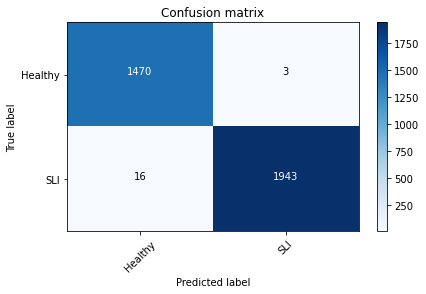

In [ ]:
label_names = ['Healthy', 'SLI']
plot_confusion_matrix(cm=Train_metrics['cm'], classes=label_names)

Confusion matrix, without normalization
[[186   0]
 [ 32 158]]


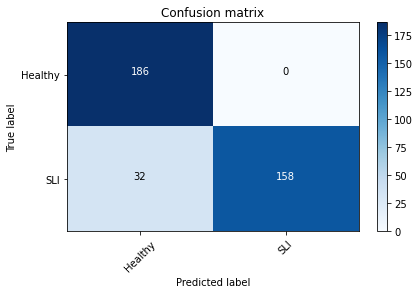

In [ ]:
label_names = ['Healthy', 'SLI']
plot_confusion_matrix(cm=Test_metrics['cm'], classes=label_names)